In [1]:
import sys
sys.path.insert(0, 'src')

import stlcg
import stlviz as viz
from stlcg import Expression
from utils import print_learning_progress, plot_add_signal_Expression

import torch
import numpy as np
import matplotlib.pyplot as plt
import importlib

/home/kaleung/.local/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


## Create traces from numpy arrays

In [2]:
t = t = np.arange(-3, 3, 0.2, dtype=np.float32)
x_np = 0.5 * np.exp(-t**2).reshape([1, t.shape[0], 1])
w_np = (0.4*np.exp(-(t + 0.5)**2) + 0.2*np.exp(-(t - 3)**2)).reshape([1, t.shape[0], 1])


# turning signals and parameters into tensors
x = torch.tensor(x_np, requires_grad=False)
w = torch.tensor(w_np, requires_grad=False)
c = torch.tensor(0.7, dtype=torch.float, requires_grad=True)
d = torch.tensor(0.5, dtype=torch.float, requires_grad=True)

# turning signals and parameters into expressions
# the benefit of using Expressions is that each expression has a name, value, and keeps track of the time dimension has been reversed
# We can also do some basic operations on the expression
# The first argument is a string describing the name of the variable, the second argument is the numerical value, the third argument indicates whether the signal has been time reversed or not.

reversed = False
x_exp = Expression('speed', x, reversed)   
w_exp = Expression('position', w, reversed)
c_exp = Expression('speed limit', c, reversed)    
d_exp = Expression('sunflowers', d, reversed)  # <--- giving it a random name
y_exp = x_exp * w_exp
z_exp = x_exp + w_exp

print(y_exp.name, z_exp.name)


speed×position speed+position


(-0.1, 1.0)

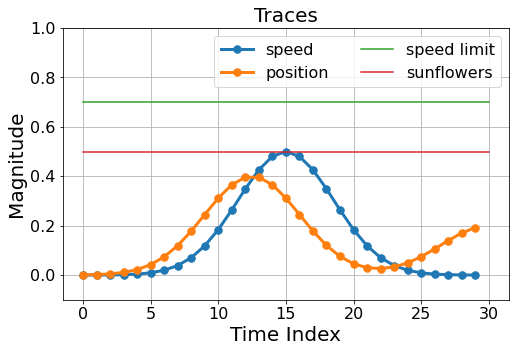

In [3]:
# Plotting out the signals and parameters
fs = 20
plt.figure(figsize=(8, 5))
plt.plot(x_np[0,:,0], ".-", linewidth=3, markersize=15, label=x_exp.name)
plt.plot(w_np[0,:,0], ".-", linewidth=3, markersize=15, label=w_exp.name)

plt.plot([0, len(t)], [c.detach().numpy()]*2, label=c_exp.name)
plt.plot([0, len(t)], [d.detach().numpy()]*2, label=d_exp.name)
plt.legend(fontsize=16, ncol=2)
plt.xticks(fontsize=fs-4)
plt.yticks(fontsize=fs-4)
plt.title("Traces", fontsize=fs)
plt.xlabel("Time Index", fontsize=fs)
plt.ylabel("Magnitude", fontsize=fs)
plt.grid()
plt.ylim([-0.1, 1.0])

# Constructing STL formulas

One way to construct formulas is to explicitly call the constructors

(◻ [0, inf]( speed < speed limit )) ∧ (◻ [2, 5]( speed×position < sunflowers ))


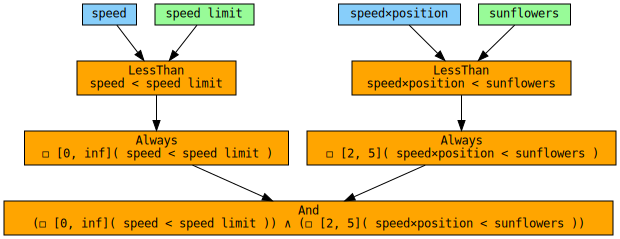

In [4]:
# note the use of Expressions and how they show up in the visualization
ϕ1 = stlcg.LessThan(lhs=x_exp, val=c_exp)
ϕ2 = stlcg.GreaterThan(lhs=w_exp, val=d_exp)
ϕ3 = stlcg.LessThan(lhs=y_exp, val=d_exp)
ϕ = stlcg.Always(subformula=ϕ1)
ψ = stlcg.Always(subformula=ϕ3, interval=[2,5])
formula = stlcg.And(subformula1=ϕ, subformula2=ψ)
print(formula)
dot = viz.make_stl_graph(formula, graph_attr=dict(size="12,12"))
# viz.save_graph(dot, "test")  # <--- to safe a graph as a pdf
dot

### Another way (preferred way) is to use the math operators which have been overloaded
 The LessThan (<), GreaterThan (>), Equal (==), Not (~), And (&), Or (|) operators have been overloaded. 
 Always, Eventually, Implies, Until, and Then have not been overloaded, and require the constructor

(◻ [0, inf]( speed < speed limit )) ∧ ((¬(♢ [2, 5]( position == sunflowers ))) ∨ (position > sunflowers))


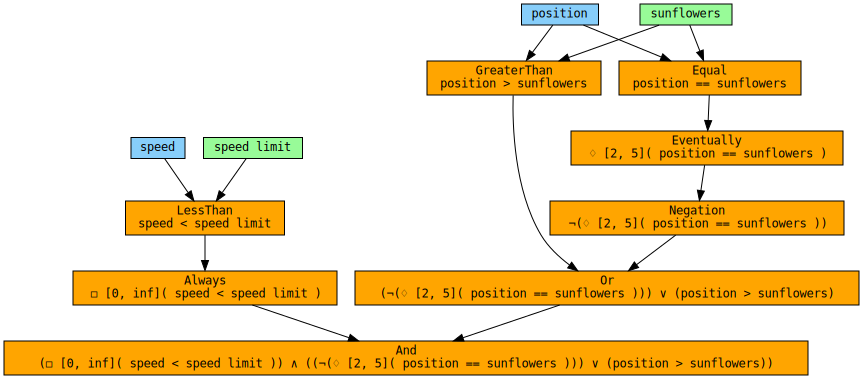

In [5]:
ϕ1 = x_exp < c_exp
ϕ2 = w_exp > d_exp 
ϕ3 = w_exp == d_exp
ϕ = stlcg.Always(subformula=ϕ1)
ψ = stlcg.Eventually(subformula=ϕ3, interval=[2,5])
formula = ϕ & (~ψ | ϕ2)
print(formula)
viz.make_stl_graph(formula)

## Evaluating the formula
##### NOTE: The signals are assumed to be BACKWARD in time. User is responsible for reversing the time dimension
You need to feed in the necessary inputs. If the formula requires multiple inputs, it takes in a tuple of length 2 where each element in the tuple is the input to each subformula, in the order they are created. If the formula requires more than two inputs, then the tuple contains a tuple, eg. (x, (y, z)). The grouping of the input traces depend on how the formula was created.

The inputs can be made up of tensors, or Expression objects.

In [13]:
# Perform time reversal on an Expression
x_exp.flip(1)  # <--- flips dimension 1, the time dimension
print(x_exp.reversed) # True means the time is reversed (i.e., backward)
x_exp.flip(1) # <--- flips the time dimension again
print(x_exp.reversed) # False means the time is no longer reversed 


False
True


False
((speed < speed limit) ∧ (position > sunflowers)) ∨ (position == sunflowers)
tensor([-0.4992, -0.4980, -0.4951, -0.4892, -0.4778, -0.4578, -0.4262, -0.3807,
        -0.3221, -0.2549, -0.1885, -0.1344, -0.1040, -0.1040, -0.1344, -0.1885,
        -0.2549, -0.3218, -0.3801, -0.4246, -0.4542, -0.4699, -0.4737, -0.4670,
        -0.4506, -0.4257, -0.3943, -0.3604, -0.3295, -0.3078],
       grad_fn=<SqueezeBackward0>)


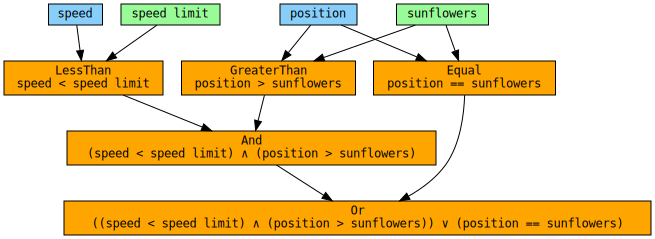

In [14]:
formula = (ϕ1 & ϕ2) | ϕ3 
inputs = (x_exp.flip(1), w_exp.flip(1)), y_exp.flip(1)   # <--- time revsering the signals
print(x_exp.reversed)
print(formula)

pscale = 1     # "pscale" is the scale used for evaluting predicates
scale = -1     # "scale" is the scale used in the maxish/minish function. <0 defaults to the true min/max
print(formula(inputs, pscale=pscale, scale=scale).squeeze())   # robustness trace
viz.make_stl_graph(formula)



# Testing grad functionality

##### Optimizing for predicate constant on RHS (pSTL)
Given a formula ϕ = □(sA < pC), and a signal sA, we want to find a value for pC such that ϕ is true. 

◻ [0, inf]( sA < pC )


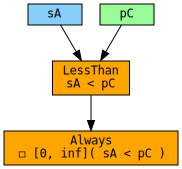

In [23]:
t = t = np.linspace(0, 20, 21, dtype=np.float32)
x_np = np.sign(t-5).reshape([1, t.shape[0], 1])

# turning signals and parameters into tensors
x = torch.tensor(x_np, requires_grad=False)
c = torch.tensor(0.6, dtype=torch.float, requires_grad=True)  # <-- requires_grad is set to True

reversed = False
x_exp = Expression('sA', x, reversed)   
c_exp = Expression('pC', c, reversed)    

lt = x_exp < c_exp
formula = stlcg.Always(subformula=lt)
print(formula)
viz.make_stl_graph(formula)

In [24]:
learning_rate = 0.05
device = torch.device("cpu")
var_dict = {'c': c_exp.value}  # <--- list of optimization variables
optimizer = torch.optim.Adam(var_dict.values(), lr=learning_rate)
scale = 0.5  # <--- scale value can increase over each iteration


iteration: 0 -- loss: 6.230 ---- c:0.600 ---- scale:0.500 ---- true value:-0.400
iteration: 20 -- loss: 0.036 ---- c:1.300 ---- scale:10.500 ---- true value:0.300
iteration: 40 -- loss: 0.035 ---- c:1.100 ---- scale:20.500 ---- true value:0.100
iteration: 60 -- loss: 0.009 ---- c:1.100 ---- scale:30.500 ---- true value:0.100
iteration: 80 -- loss: 0.032 ---- c:1.100 ---- scale:40.500 ---- true value:0.100
iteration: 100 -- loss: 0.045 ---- c:1.100 ---- scale:50.500 ---- true value:0.100
iteration: 120 -- loss: 0.046 ---- c:1.000 ---- scale:60.500 ---- true value:0.000
iteration: 140 -- loss: 0.039 ---- c:1.000 ---- scale:70.500 ---- true value:0.000
iteration: 160 -- loss: 0.034 ---- c:1.000 ---- scale:80.500 ---- true value:0.000
iteration: 180 -- loss: 0.031 ---- c:1.000 ---- scale:90.500 ---- true value:0.000


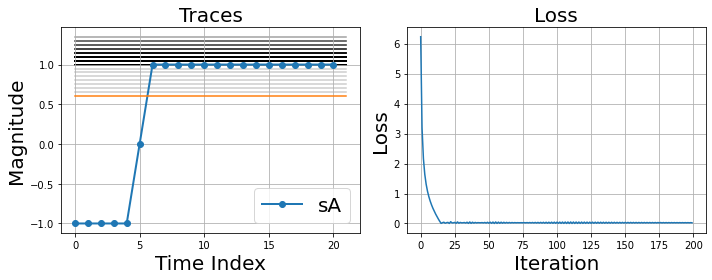

In [25]:
max_epochs = 200
x_exp.flip(1)
losses = []
scales = []

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
fmt = {"linewidth": 2, "markersize": 12}
ax = plot_add_signal_Expression(ax, x_exp, **fmt)
ax.plot([0,len(t)], [c.detach(), c.detach()])
for i in range(max_epochs):
    sc = scale + i * 0.5
    scales.append(sc)
    loss = torch.abs(formula.robustness(x_exp, scale=sc))
    # true_loss = torch.abs(formula.robustness(x_exp, scale=0))
    losses.append(loss.detach().squeeze())
    if i % 20 == 0:
        print_learning_progress(formula, x_exp, var_dict, i, loss, sc)
    loss.backward()
    with torch.no_grad():
        c -= learning_rate * c.grad
        c.grad.zero_()
    ax.plot([0,len(t)], [c.detach(), c.detach()], c='k', alpha=0.2, zorder=-2)

ax.set_title("Traces", fontsize=fs)
ax.set_xlabel("Time Index", fontsize=fs)
ax.set_ylabel("Magnitude", fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

ax = axs[1]
ax.plot(range(max_epochs), losses)
ax.set_title("Loss", fontsize=fs)
ax.set_xlabel("Iteration", fontsize=fs)
ax.set_ylabel("Loss", fontsize=fs)
ax.grid()
plt.tight_layout()

##### Optimizing for parameters that generate signal 
The signal is generated from a function with parameters to be optimized such that the generated signal will satisfy
(sA < 0.2) U_[5,10] (◊ □ sA > 0.8)

(sA < 0.2) U (♢ [0, inf]( ◻ [0, inf]( sA > 0.8 ) ))


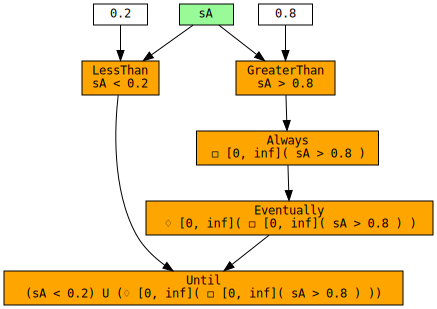

In [30]:
N = 21
t = torch.linspace(0, 20, N, dtype=torch.float, requires_grad=False).reshape([1, N, 1])
c = torch.tensor(0., dtype=torch.float, requires_grad=True)
d = 0.2
f = 0.8

x = torch.sigmoid(t - c)
reversed = False
x_exp = Expression('sA', x, reversed)   
ϕ = x_exp < d
ψ = stlcg.Eventually(stlcg.Always(x_exp > f))
formula = stlcg.Until(ϕ, ψ, interval=[5,10])
print(formula)
viz.make_stl_graph(formula)

In [31]:
learning_rate = 0.5
device = torch.device("cpu")
var_dict = {'c': c}  # <--- list of optimization variables
optimizer = torch.optim.Adam(var_dict.values(), lr=learning_rate)
scale = 0.5


iteration: 0 -- loss: 0.793 ---- c:0.000 ---- scale:0.000 ---- true value:-0.793
iteration: 20 -- loss: 0.793 ---- c:0.069 ---- scale:0.000 ---- true value:-0.793
iteration: 40 -- loss: 0.792 ---- c:0.142 ---- scale:0.000 ---- true value:-0.792
iteration: 60 -- loss: 0.792 ---- c:0.222 ---- scale:0.000 ---- true value:-0.792
iteration: 80 -- loss: 0.791 ---- c:0.308 ---- scale:0.000 ---- true value:-0.791
iteration: 100 -- loss: 0.790 ---- c:0.402 ---- scale:0.000 ---- true value:-0.790
iteration: 120 -- loss: 0.789 ---- c:0.505 ---- scale:0.000 ---- true value:-0.789
iteration: 140 -- loss: 0.788 ---- c:0.620 ---- scale:0.000 ---- true value:-0.788
iteration: 160 -- loss: 0.786 ---- c:0.750 ---- scale:0.000 ---- true value:-0.786
iteration: 180 -- loss: 0.784 ---- c:0.898 ---- scale:0.000 ---- true value:-0.784
iteration: 200 -- loss: 0.781 ---- c:1.072 ---- scale:0.000 ---- true value:-0.781
iteration: 220 -- loss: 0.776 ---- c:1.279 ---- scale:0.000 ---- true value:-0.776
iteration:

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

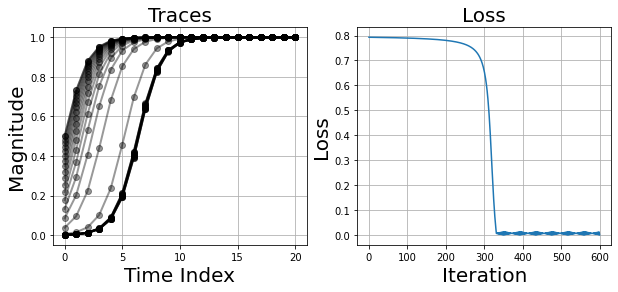

In [32]:
max_epochs = 600
fs = 20
losses = []
scales = []

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs[0]
fmt = {"linewidth": 2, "markersize": 12, "alpha": 0.4, "color": 'k'}
ax = plot_add_signal_Expression(ax, x_exp, **fmt)
# ax.plot([0,len(t)], [c.detach(), c.detach()])

for i in range(max_epochs):
    x = torch.sigmoid(t - c).flip(1)
    sc = 0 # scale + i * 0.5   # <--- scale can be annealed, or set to 0. 
    scales.append(sc)
    loss = torch.abs(formula.robustness((x, x), scale=sc))
    # true_loss = torch.abs(formula.robustness(x, scale=0))
    losses.append(loss.detach().squeeze())
    if i % 20 == 0:
        print_learning_progress(formula, (x, x), var_dict, i, loss, sc)
        x_exp = Expression('sA', x, True)   
        ax = plot_add_signal_Expression(ax, x_exp, **fmt)
    loss.backward()
    with torch.no_grad():
        c -= learning_rate * c.grad
        c.grad.zero_()
    
ax.set_title("Traces", fontsize=fs)
ax.set_xlabel("Time Index", fontsize=fs)
ax.set_ylabel("Magnitude", fontsize=fs)
ax.grid()

ax = axs[1]
ax.plot(range(max_epochs), losses)
ax.set_title("Loss", fontsize=fs)
ax.set_xlabel("Iteration", fontsize=fs)
ax.set_ylabel("Loss", fontsize=fs)
ax.grid()
plt.tight_layout